In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [2]:
merged_cohort = pd.read_csv("merged_file.csv")

In [3]:
merged_cohort.head()

,Outcome_Occlusion_MI,Age,HR,PR,QRSd,mfpQRSaxis,fpTaxis,txzQRSaxis,QRSTangle,mQRSTangle,...,tamp_III,tamp_aVR,tamp_aVL,tamp_aVF,tamp_V1,tamp_V2,tamp_V3,tamp_V4,tamp_V5,tamp_V6
0,0,78.0,116.0,94.0,107.0,7.0,107.0,79.0,163.0,142.0,...,46.0,0.0,-61.0,63.0,132.0,201.0,319.0,125.0,59.0,-65.0
1,0,84.0,71.0,174.0,136.0,53.0,NaN,51.0,137.0,113.0,...,69.0,51.0,32.0,-72.0,344.0,742.0,668.0,172.0,-153.0,23.0
2,0,76.0,73.0,191.0,110.0,-72.0,56.0,110.0,153.0,147.0,...,50.0,-131.0,29.0,103.0,-50.0,81.0,186.0,155.0,101.0,60.0
3,0,53.0,76.0,134.0,97.0,71.0,58.0,117.0,50.0,78.0,...,195.0,-249.0,-38.0,266.0,-101.0,89.0,450.0,545.0,656.0,272.0
4,0,34.0,76.0,160.0,87.0,43.0,70.0,26.0,45.0,38.0,...,169.0,-150.0,-59.0,199.0,75.0,192.0,128.0,103.0,127.0,150.0


In [4]:
y = merged_cohort['Outcome_Occlusion_MI']
X = merged_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,  # 30% for val+test (which is 15%+15%)
    stratify=y,
    random_state=99
)
'''
# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15% of original data
    stratify=y_temp,  # Maintain stratification in this split too
    random_state=99
)
'''
# Verify the proportions
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
#print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

Training set: 5850 samples (80.0%)
Validation set: 1463 samples (20.0%)


In [5]:
for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    #X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
#y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
#X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
#X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_99104\2349841912.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_99104\2349841912.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [6]:
def train_clf_RF(n_estimators=20):
    clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', n_jobs=-1, random_state=42,
                            max_features='log2', 
                            n_estimators=n_estimators,
                            min_samples_split=0.01,
                            min_samples_leaf=0.005,
                            min_impurity_decrease=1e-2,
                            bootstrap=True,
                            ccp_alpha=1e-2,
                            max_samples=0.75,
                            oob_score=True)
    clf = CalibratedClassifierCV(clf, cv=5, method="isotonic")
    return clf

In [7]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'RF (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [9]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

Training with 10-fold cross-validation


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.240 [00:00<?, ?it/s]
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.v

Estimators: 10, Mean CV AUROC: 0.8641 ± 0.0303


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-package

Estimators: 11, Mean CV AUROC: 0.8661 ± 0.0293


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-package

Estimators: 12, Mean CV AUROC: 0.8646 ± 0.0297


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-package

Estimators: 13, Mean CV AUROC: 0.8668 ± 0.0300


C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\arthu\PycharmProjects\Thesis\.venv\Lib\site-package

Estimators: 14, Mean CV AUROC: 0.8685 ± 0.0274


  2%|████▎                                                                                                                                                                                                            | 5/240 [00:18<15:02,  3.84s/it]

Estimators: 15, Mean CV AUROC: 0.8700 ± 0.0264


  2%|█████▏                                                                                                                                                                                                           | 6/240 [00:22<15:15,  3.91s/it]

Estimators: 16, Mean CV AUROC: 0.8723 ± 0.0269


  3%|██████                                                                                                                                                                                                           | 7/240 [00:27<15:27,  3.98s/it]

Estimators: 17, Mean CV AUROC: 0.8730 ± 0.0279


  3%|██████▉                                                                                                                                                                                                          | 8/240 [00:31<15:40,  4.05s/it]

Estimators: 18, Mean CV AUROC: 0.8732 ± 0.0287


  4%|███████▊                                                                                                                                                                                                         | 9/240 [00:35<16:01,  4.16s/it]

Estimators: 19, Mean CV AUROC: 0.8742 ± 0.0286


  4%|████████▋                                                                                                                                                                                                       | 10/240 [00:40<16:24,  4.28s/it]

Estimators: 20, Mean CV AUROC: 0.8751 ± 0.0282


  5%|██████████▍                                                                                                                                                                                                     | 12/240 [00:49<16:44,  4.41s/it]

Estimators: 21, Mean CV AUROC: 0.8726 ± 0.0290


  5%|███████████▎                                                                                                                                                                                                    | 13/240 [00:53<16:49,  4.45s/it]

Estimators: 22, Mean CV AUROC: 0.8737 ± 0.0285


  6%|████████████▏                                                                                                                                                                                                   | 14/240 [00:58<16:55,  4.49s/it]

Estimators: 23, Mean CV AUROC: 0.8740 ± 0.0289
Estimators: 24, Mean CV AUROC: 0.8758 ± 0.0273


  7%|█████████████▊                                                                                                                                                                                                  | 16/240 [01:08<17:22,  4.66s/it]

Estimators: 25, Mean CV AUROC: 0.8729 ± 0.0272


  7%|██████████████▋                                                                                                                                                                                                 | 17/240 [01:12<17:31,  4.72s/it]

Estimators: 26, Mean CV AUROC: 0.8747 ± 0.0267


  8%|███████████████▌                                                                                                                                                                                                | 18/240 [01:17<17:43,  4.79s/it]

Estimators: 27, Mean CV AUROC: 0.8757 ± 0.0269
Estimators: 28, Mean CV AUROC: 0.8761 ± 0.0273


  8%|████████████████▍                                                                                                                                                                                               | 19/240 [01:23<18:12,  4.94s/it]

Estimators: 29, Mean CV AUROC: 0.8762 ± 0.0275


  9%|██████████████████▏                                                                                                                                                                                             | 21/240 [01:33<18:35,  5.09s/it]

Estimators: 30, Mean CV AUROC: 0.8755 ± 0.0267
Estimators: 31, Mean CV AUROC: 0.8768 ± 0.0267


  9%|███████████████████                                                                                                                                                                                             | 22/240 [01:39<19:05,  5.25s/it]

Estimators: 32, Mean CV AUROC: 0.8770 ± 0.0272


 10%|████████████████████▊                                                                                                                                                                                           | 24/240 [01:50<19:14,  5.35s/it]

Estimators: 33, Mean CV AUROC: 0.8758 ± 0.0273


 10%|█████████████████████▋                                                                                                                                                                                          | 25/240 [01:55<19:11,  5.36s/it]

Estimators: 34, Mean CV AUROC: 0.8751 ± 0.0293
Estimators: 35, Mean CV AUROC: 0.8772 ± 0.0288


 11%|███████████████████████▍                                                                                                                                                                                        | 27/240 [02:08<20:53,  5.88s/it]

Estimators: 36, Mean CV AUROC: 0.8770 ± 0.0281


 12%|████████████████████████▎                                                                                                                                                                                       | 28/240 [02:14<20:48,  5.89s/it]

Estimators: 37, Mean CV AUROC: 0.8768 ± 0.0279


 12%|█████████████████████████▏                                                                                                                                                                                      | 29/240 [02:20<21:07,  6.01s/it]

Estimators: 38, Mean CV AUROC: 0.8767 ± 0.0284


 12%|██████████████████████████                                                                                                                                                                                      | 30/240 [02:26<21:14,  6.07s/it]

Estimators: 39, Mean CV AUROC: 0.8754 ± 0.0295


 13%|██████████████████████████▊                                                                                                                                                                                     | 31/240 [02:33<21:15,  6.10s/it]

Estimators: 40, Mean CV AUROC: 0.8761 ± 0.0285


 13%|███████████████████████████▋                                                                                                                                                                                    | 32/240 [02:39<21:19,  6.15s/it]

Estimators: 41, Mean CV AUROC: 0.8761 ± 0.0279


 14%|████████████████████████████▌                                                                                                                                                                                   | 33/240 [02:45<21:32,  6.24s/it]

Estimators: 42, Mean CV AUROC: 0.8771 ± 0.0272
Estimators: 43, Mean CV AUROC: 0.8780 ± 0.0273


 14%|█████████████████████████████▍                                                                                                                                                                                  | 34/240 [02:52<22:20,  6.51s/it]

Estimators: 44, Mean CV AUROC: 0.8787 ± 0.0281


 15%|███████████████████████████████▏                                                                                                                                                                                | 36/240 [03:06<22:34,  6.64s/it]

Estimators: 45, Mean CV AUROC: 0.8774 ± 0.0273


 15%|████████████████████████████████                                                                                                                                                                                | 37/240 [03:13<22:33,  6.67s/it]

Estimators: 46, Mean CV AUROC: 0.8771 ± 0.0281


 16%|████████████████████████████████▉                                                                                                                                                                               | 38/240 [03:19<22:19,  6.63s/it]

Estimators: 47, Mean CV AUROC: 0.8755 ± 0.0287


 16%|█████████████████████████████████▊                                                                                                                                                                              | 39/240 [03:26<22:12,  6.63s/it]

Estimators: 48, Mean CV AUROC: 0.8755 ± 0.0289


 17%|██████████████████████████████████▋                                                                                                                                                                             | 40/240 [03:33<22:10,  6.65s/it]

Estimators: 49, Mean CV AUROC: 0.8764 ± 0.0290


 17%|███████████████████████████████████▌                                                                                                                                                                            | 41/240 [03:40<22:12,  6.70s/it]

Estimators: 50, Mean CV AUROC: 0.8754 ± 0.0288


 18%|████████████████████████████████████▍                                                                                                                                                                           | 42/240 [03:46<22:13,  6.74s/it]

Estimators: 51, Mean CV AUROC: 0.8759 ± 0.0286


 18%|█████████████████████████████████████▎                                                                                                                                                                          | 43/240 [03:53<22:24,  6.83s/it]

Estimators: 52, Mean CV AUROC: 0.8747 ± 0.0291


 18%|██████████████████████████████████████▏                                                                                                                                                                         | 44/240 [04:01<22:36,  6.92s/it]

Estimators: 53, Mean CV AUROC: 0.8740 ± 0.0295


 19%|███████████████████████████████████████                                                                                                                                                                         | 45/240 [04:08<23:12,  7.14s/it]

Estimators: 54, Mean CV AUROC: 0.8743 ± 0.0299


 19%|███████████████████████████████████████▊                                                                                                                                                                        | 46/240 [04:16<23:46,  7.35s/it]

Estimators: 55, Mean CV AUROC: 0.8758 ± 0.0301


 20%|████████████████████████████████████████▋                                                                                                                                                                       | 47/240 [04:24<24:09,  7.51s/it]

Estimators: 56, Mean CV AUROC: 0.8759 ± 0.0297


 20%|█████████████████████████████████████████▌                                                                                                                                                                      | 48/240 [04:32<24:51,  7.77s/it]

Estimators: 57, Mean CV AUROC: 0.8776 ± 0.0282


 20%|██████████████████████████████████████████▍                                                                                                                                                                     | 49/240 [04:41<25:20,  7.96s/it]

Estimators: 58, Mean CV AUROC: 0.8768 ± 0.0278


 21%|███████████████████████████████████████████▎                                                                                                                                                                    | 50/240 [04:49<25:38,  8.10s/it]

Estimators: 59, Mean CV AUROC: 0.8766 ± 0.0287


 21%|████████████████████████████████████████████▏                                                                                                                                                                   | 51/240 [04:58<26:00,  8.26s/it]

Estimators: 60, Mean CV AUROC: 0.8770 ± 0.0283


 22%|█████████████████████████████████████████████                                                                                                                                                                   | 52/240 [05:06<26:10,  8.35s/it]

Estimators: 61, Mean CV AUROC: 0.8767 ± 0.0282


 22%|█████████████████████████████████████████████▉                                                                                                                                                                  | 53/240 [05:15<26:08,  8.39s/it]

Estimators: 62, Mean CV AUROC: 0.8761 ± 0.0293


 22%|██████████████████████████████████████████████▊                                                                                                                                                                 | 54/240 [05:23<26:10,  8.45s/it]

Estimators: 63, Mean CV AUROC: 0.8755 ± 0.0300


 23%|███████████████████████████████████████████████▋                                                                                                                                                                | 55/240 [05:32<26:25,  8.57s/it]

Estimators: 64, Mean CV AUROC: 0.8766 ± 0.0286


 23%|████████████████████████████████████████████████▌                                                                                                                                                               | 56/240 [05:42<27:00,  8.81s/it]

Estimators: 65, Mean CV AUROC: 0.8765 ± 0.0288


 24%|█████████████████████████████████████████████████▍                                                                                                                                                              | 57/240 [05:51<27:25,  8.99s/it]

Estimators: 66, Mean CV AUROC: 0.8768 ± 0.0280


 24%|██████████████████████████████████████████████████▎                                                                                                                                                             | 58/240 [06:00<27:21,  9.02s/it]

Estimators: 67, Mean CV AUROC: 0.8762 ± 0.0286


 25%|███████████████████████████████████████████████████▏                                                                                                                                                            | 59/240 [06:09<27:27,  9.10s/it]

Estimators: 68, Mean CV AUROC: 0.8762 ± 0.0273


 25%|████████████████████████████████████████████████████                                                                                                                                                            | 60/240 [06:19<27:24,  9.13s/it]

Estimators: 69, Mean CV AUROC: 0.8774 ± 0.0288


 25%|████████████████████████████████████████████████████▊                                                                                                                                                           | 61/240 [06:28<27:22,  9.18s/it]

Estimators: 70, Mean CV AUROC: 0.8764 ± 0.0281


 26%|█████████████████████████████████████████████████████▋                                                                                                                                                          | 62/240 [06:37<26:58,  9.09s/it]

Estimators: 71, Mean CV AUROC: 0.8757 ± 0.0280


 26%|██████████████████████████████████████████████████████▌                                                                                                                                                         | 63/240 [06:46<26:33,  9.00s/it]

Estimators: 72, Mean CV AUROC: 0.8759 ± 0.0285


 27%|███████████████████████████████████████████████████████▍                                                                                                                                                        | 64/240 [06:54<26:17,  8.96s/it]

Estimators: 73, Mean CV AUROC: 0.8773 ± 0.0268


 27%|████████████████████████████████████████████████████████▎                                                                                                                                                       | 65/240 [07:03<26:05,  8.95s/it]

Estimators: 74, Mean CV AUROC: 0.8760 ± 0.0284


 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                      | 66/240 [07:13<26:09,  9.02s/it]

Estimators: 75, Mean CV AUROC: 0.8769 ± 0.0275


 28%|██████████████████████████████████████████████████████████                                                                                                                                                      | 67/240 [07:22<26:23,  9.15s/it]

Estimators: 76, Mean CV AUROC: 0.8761 ± 0.0283


 28%|██████████████████████████████████████████████████████████▉                                                                                                                                                     | 68/240 [07:32<26:34,  9.27s/it]

Estimators: 77, Mean CV AUROC: 0.8770 ± 0.0284


 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                    | 69/240 [07:41<26:49,  9.41s/it]

Estimators: 78, Mean CV AUROC: 0.8765 ± 0.0286


 29%|████████████████████████████████████████████████████████████▋                                                                                                                                                   | 70/240 [07:51<27:03,  9.55s/it]

Estimators: 79, Mean CV AUROC: 0.8763 ± 0.0276


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                                  | 71/240 [08:01<27:08,  9.64s/it]

Estimators: 80, Mean CV AUROC: 0.8760 ± 0.0284


 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                                 | 72/240 [08:11<27:00,  9.64s/it]

Estimators: 81, Mean CV AUROC: 0.8760 ± 0.0278


 30%|███████████████████████████████████████████████████████████████▎                                                                                                                                                | 73/240 [08:21<27:02,  9.71s/it]

Estimators: 82, Mean CV AUROC: 0.8762 ± 0.0290


 31%|████████████████████████████████████████████████████████████████▏                                                                                                                                               | 74/240 [08:31<27:12,  9.83s/it]

Estimators: 83, Mean CV AUROC: 0.8762 ± 0.0285


 31%|█████████████████████████████████████████████████████████████████                                                                                                                                               | 75/240 [08:41<27:25,  9.97s/it]

Estimators: 84, Mean CV AUROC: 0.8761 ± 0.0288


 32%|█████████████████████████████████████████████████████████████████▊                                                                                                                                              | 76/240 [08:51<27:37, 10.11s/it]

Estimators: 85, Mean CV AUROC: 0.8761 ± 0.0285


 32%|██████████████████████████████████████████████████████████████████▋                                                                                                                                             | 77/240 [09:02<27:34, 10.15s/it]

Estimators: 86, Mean CV AUROC: 0.8759 ± 0.0278


 32%|███████████████████████████████████████████████████████████████████▌                                                                                                                                            | 78/240 [09:12<27:34, 10.22s/it]

Estimators: 87, Mean CV AUROC: 0.8763 ± 0.0273


 33%|████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 79/240 [09:22<27:28, 10.24s/it]

Estimators: 88, Mean CV AUROC: 0.8756 ± 0.0266


 33%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 80/240 [09:33<27:47, 10.42s/it]

Estimators: 89, Mean CV AUROC: 0.8760 ± 0.0270


 34%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 81/240 [09:44<28:01, 10.58s/it]

Estimators: 90, Mean CV AUROC: 0.8758 ± 0.0264


 34%|███████████████████████████████████████████████████████████████████████                                                                                                                                         | 82/240 [09:55<28:15, 10.73s/it]

Estimators: 91, Mean CV AUROC: 0.8762 ± 0.0263


 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 83/240 [10:07<29:07, 11.13s/it]

Estimators: 92, Mean CV AUROC: 0.8767 ± 0.0267


 35%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 84/240 [10:19<29:18, 11.28s/it]

Estimators: 93, Mean CV AUROC: 0.8769 ± 0.0270


 35%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 85/240 [10:30<29:13, 11.32s/it]

Estimators: 94, Mean CV AUROC: 0.8764 ± 0.0268


 36%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 86/240 [10:41<28:53, 11.26s/it]

Estimators: 95, Mean CV AUROC: 0.8756 ± 0.0268


 36%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 87/240 [10:53<28:40, 11.25s/it]

Estimators: 96, Mean CV AUROC: 0.8766 ± 0.0263


 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 88/240 [11:04<28:30, 11.25s/it]

Estimators: 97, Mean CV AUROC: 0.8757 ± 0.0274


 37%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 89/240 [11:16<29:02, 11.54s/it]

Estimators: 98, Mean CV AUROC: 0.8758 ± 0.0276


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 90/240 [11:28<29:19, 11.73s/it]

Estimators: 99, Mean CV AUROC: 0.8763 ± 0.0274


 38%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 91/240 [11:41<29:34, 11.91s/it]

Estimators: 100, Mean CV AUROC: 0.8761 ± 0.0268


 38%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 92/240 [11:53<30:09, 12.23s/it]

Estimators: 101, Mean CV AUROC: 0.8764 ± 0.0268


 39%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 93/240 [12:07<30:56, 12.63s/it]

Estimators: 102, Mean CV AUROC: 0.8758 ± 0.0269


 39%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 94/240 [12:20<30:40, 12.61s/it]

Estimators: 103, Mean CV AUROC: 0.8763 ± 0.0262


 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 95/240 [12:32<30:36, 12.66s/it]

Estimators: 104, Mean CV AUROC: 0.8757 ± 0.0264


 40%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 96/240 [12:47<31:50, 13.27s/it]

Estimators: 105, Mean CV AUROC: 0.8765 ± 0.0264


 40%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 97/240 [13:02<32:33, 13.66s/it]

Estimators: 106, Mean CV AUROC: 0.8762 ± 0.0263


 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 98/240 [13:16<32:29, 13.73s/it]

Estimators: 107, Mean CV AUROC: 0.8762 ± 0.0257


 41%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 99/240 [13:30<32:32, 13.85s/it]

Estimators: 108, Mean CV AUROC: 0.8764 ± 0.0254


 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 100/240 [13:44<32:19, 13.86s/it]

Estimators: 109, Mean CV AUROC: 0.8765 ± 0.0254


 42%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 101/240 [13:57<32:05, 13.85s/it]

Estimators: 110, Mean CV AUROC: 0.8759 ± 0.0256


 42%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 102/240 [14:12<32:02, 13.93s/it]

Estimators: 111, Mean CV AUROC: 0.8760 ± 0.0256


 43%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 103/240 [14:26<31:53, 13.96s/it]

Estimators: 112, Mean CV AUROC: 0.8771 ± 0.0252


 43%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 104/240 [14:40<32:07, 14.17s/it]

Estimators: 113, Mean CV AUROC: 0.8777 ± 0.0250


 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 105/240 [14:55<31:59, 14.22s/it]

Estimators: 114, Mean CV AUROC: 0.8781 ± 0.0254


 44%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 106/240 [15:09<32:12, 14.42s/it]

Estimators: 115, Mean CV AUROC: 0.8779 ± 0.0254


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 107/240 [15:24<32:14, 14.54s/it]

Estimators: 116, Mean CV AUROC: 0.8766 ± 0.0255


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 108/240 [15:39<32:18, 14.69s/it]

Estimators: 117, Mean CV AUROC: 0.8764 ± 0.0252


 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 109/240 [15:54<32:09, 14.73s/it]

Estimators: 118, Mean CV AUROC: 0.8774 ± 0.0255


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 110/240 [16:10<32:23, 14.95s/it]

Estimators: 119, Mean CV AUROC: 0.8771 ± 0.0253


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 111/240 [16:25<32:14, 15.00s/it]

Estimators: 120, Mean CV AUROC: 0.8772 ± 0.0251


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 112/240 [16:40<32:16, 15.13s/it]

Estimators: 121, Mean CV AUROC: 0.8770 ± 0.0258


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 113/240 [16:55<32:02, 15.14s/it]

Estimators: 122, Mean CV AUROC: 0.8769 ± 0.0260


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 114/240 [17:11<32:00, 15.24s/it]

Estimators: 123, Mean CV AUROC: 0.8769 ± 0.0257


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 115/240 [17:26<31:57, 15.34s/it]

Estimators: 124, Mean CV AUROC: 0.8776 ± 0.0249


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 116/240 [17:42<31:56, 15.46s/it]

Estimators: 125, Mean CV AUROC: 0.8783 ± 0.0247


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 117/240 [17:58<31:40, 15.45s/it]

Estimators: 126, Mean CV AUROC: 0.8786 ± 0.0245


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 118/240 [18:13<31:17, 15.39s/it]

Estimators: 127, Mean CV AUROC: 0.8784 ± 0.0248
Estimators: 128, Mean CV AUROC: 0.8792 ± 0.0249


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 119/240 [18:30<31:52, 15.81s/it]

Estimators: 129, Mean CV AUROC: 0.8798 ± 0.0247


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 121/240 [19:02<31:46, 16.02s/it]

Estimators: 130, Mean CV AUROC: 0.8789 ± 0.0244


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 122/240 [19:18<31:18, 15.92s/it]

Estimators: 131, Mean CV AUROC: 0.8792 ± 0.0247


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 123/240 [19:34<30:53, 15.84s/it]

Estimators: 132, Mean CV AUROC: 0.8790 ± 0.0251


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 124/240 [19:49<30:36, 15.83s/it]

Estimators: 133, Mean CV AUROC: 0.8793 ± 0.0252


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/240 [20:05<30:19, 15.82s/it]

Estimators: 134, Mean CV AUROC: 0.8797 ± 0.0250


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 126/240 [20:21<30:05, 15.84s/it]

Estimators: 135, Mean CV AUROC: 0.8790 ± 0.0258


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 127/240 [20:37<29:57, 15.91s/it]

Estimators: 136, Mean CV AUROC: 0.8790 ± 0.0263


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 128/240 [20:53<29:52, 16.01s/it]

Estimators: 137, Mean CV AUROC: 0.8794 ± 0.0261
Estimators: 138, Mean CV AUROC: 0.8802 ± 0.0256


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 129/240 [21:11<30:30, 16.49s/it]

Estimators: 139, Mean CV AUROC: 0.8804 ± 0.0255


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 130/240 [21:29<30:58, 16.90s/it]

Estimators: 140, Mean CV AUROC: 0.8807 ± 0.0256


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 132/240 [22:03<30:32, 16.96s/it]

Estimators: 141, Mean CV AUROC: 0.8803 ± 0.0257


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 133/240 [22:20<30:05, 16.87s/it]

Estimators: 142, Mean CV AUROC: 0.8801 ± 0.0260


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 134/240 [22:37<29:55, 16.94s/it]

Estimators: 143, Mean CV AUROC: 0.8799 ± 0.0261


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 135/240 [22:53<29:27, 16.83s/it]

Estimators: 144, Mean CV AUROC: 0.8802 ± 0.0259


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 136/240 [23:10<29:11, 16.84s/it]

Estimators: 145, Mean CV AUROC: 0.8794 ± 0.0260


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 137/240 [23:27<28:59, 16.89s/it]

Estimators: 146, Mean CV AUROC: 0.8791 ± 0.0256


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 138/240 [23:44<28:48, 16.94s/it]

Estimators: 147, Mean CV AUROC: 0.8791 ± 0.0258


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 139/240 [24:02<28:36, 17.00s/it]

Estimators: 148, Mean CV AUROC: 0.8795 ± 0.0253


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 140/240 [24:19<28:27, 17.08s/it]

Estimators: 149, Mean CV AUROC: 0.8791 ± 0.0256


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 141/240 [24:36<28:20, 17.18s/it]

Estimators: 150, Mean CV AUROC: 0.8787 ± 0.0259


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 142/240 [24:54<28:19, 17.34s/it]

Estimators: 151, Mean CV AUROC: 0.8792 ± 0.0261


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 143/240 [25:11<28:09, 17.42s/it]

Estimators: 152, Mean CV AUROC: 0.8792 ± 0.0267


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 144/240 [25:29<27:59, 17.49s/it]

Estimators: 153, Mean CV AUROC: 0.8791 ± 0.0256


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 145/240 [25:47<27:50, 17.58s/it]

Estimators: 154, Mean CV AUROC: 0.8789 ± 0.0261


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 146/240 [26:05<27:37, 17.63s/it]

Estimators: 155, Mean CV AUROC: 0.8797 ± 0.0258


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 147/240 [26:23<27:28, 17.73s/it]

Estimators: 156, Mean CV AUROC: 0.8803 ± 0.0256


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 148/240 [26:41<27:18, 17.81s/it]

Estimators: 157, Mean CV AUROC: 0.8797 ± 0.0262


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 149/240 [26:59<27:09, 17.91s/it]

Estimators: 158, Mean CV AUROC: 0.8795 ± 0.0265


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 150/240 [27:17<26:57, 17.97s/it]

Estimators: 159, Mean CV AUROC: 0.8787 ± 0.0258


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 151/240 [27:35<26:47, 18.06s/it]

Estimators: 160, Mean CV AUROC: 0.8790 ± 0.0263


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 152/240 [27:54<26:49, 18.29s/it]

Estimators: 161, Mean CV AUROC: 0.8786 ± 0.0262


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 153/240 [28:13<26:49, 18.50s/it]

Estimators: 162, Mean CV AUROC: 0.8786 ± 0.0261


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 154/240 [28:31<26:21, 18.39s/it]

Estimators: 163, Mean CV AUROC: 0.8785 ± 0.0265


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 155/240 [28:50<26:09, 18.47s/it]

Estimators: 164, Mean CV AUROC: 0.8790 ± 0.0261


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 156/240 [29:08<25:47, 18.42s/it]

Estimators: 165, Mean CV AUROC: 0.8790 ± 0.0264


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 157/240 [29:27<25:43, 18.59s/it]

Estimators: 166, Mean CV AUROC: 0.8792 ± 0.0263


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 158/240 [29:46<25:43, 18.82s/it]

Estimators: 167, Mean CV AUROC: 0.8793 ± 0.0263


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 159/240 [30:06<25:41, 19.03s/it]

Estimators: 168, Mean CV AUROC: 0.8794 ± 0.0264


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 160/240 [30:24<25:09, 18.86s/it]

Estimators: 169, Mean CV AUROC: 0.8796 ± 0.0263


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 161/240 [30:44<24:56, 18.95s/it]

Estimators: 170, Mean CV AUROC: 0.8801 ± 0.0258


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 162/240 [31:03<24:56, 19.19s/it]

Estimators: 171, Mean CV AUROC: 0.8792 ± 0.0260


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 163/240 [31:23<24:44, 19.27s/it]

Estimators: 172, Mean CV AUROC: 0.8797 ± 0.0258


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 164/240 [31:43<24:36, 19.43s/it]

Estimators: 173, Mean CV AUROC: 0.8795 ± 0.0261


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 165/240 [32:03<24:30, 19.61s/it]

Estimators: 174, Mean CV AUROC: 0.8795 ± 0.0264


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 166/240 [32:23<24:18, 19.71s/it]

Estimators: 175, Mean CV AUROC: 0.8789 ± 0.0268


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 167/240 [32:42<23:45, 19.53s/it]

Estimators: 176, Mean CV AUROC: 0.8786 ± 0.0271


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 168/240 [33:01<23:21, 19.46s/it]

Estimators: 177, Mean CV AUROC: 0.8786 ± 0.0260


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 169/240 [33:22<23:24, 19.79s/it]

Estimators: 178, Mean CV AUROC: 0.8791 ± 0.0261


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 170/240 [33:42<23:16, 19.95s/it]

Estimators: 179, Mean CV AUROC: 0.8792 ± 0.0261


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 171/240 [34:03<23:12, 20.18s/it]

Estimators: 180, Mean CV AUROC: 0.8791 ± 0.0264


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 172/240 [34:24<23:09, 20.44s/it]

Estimators: 181, Mean CV AUROC: 0.8796 ± 0.0259


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 173/240 [34:44<22:44, 20.37s/it]

Estimators: 182, Mean CV AUROC: 0.8793 ± 0.0258


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 174/240 [35:04<22:18, 20.28s/it]

Estimators: 183, Mean CV AUROC: 0.8798 ± 0.0260


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 175/240 [35:24<21:50, 20.16s/it]

Estimators: 184, Mean CV AUROC: 0.8792 ± 0.0264


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 176/240 [35:45<21:45, 20.40s/it]

Estimators: 185, Mean CV AUROC: 0.8788 ± 0.0264


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 177/240 [36:07<21:56, 20.89s/it]

Estimators: 186, Mean CV AUROC: 0.8792 ± 0.0265


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 178/240 [36:28<21:40, 20.98s/it]

Estimators: 187, Mean CV AUROC: 0.8794 ± 0.0263


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 179/240 [36:49<21:17, 20.93s/it]

Estimators: 188, Mean CV AUROC: 0.8793 ± 0.0260


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 180/240 [37:09<20:45, 20.75s/it]

Estimators: 189, Mean CV AUROC: 0.8797 ± 0.0260


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 181/240 [37:30<20:20, 20.68s/it]

Estimators: 190, Mean CV AUROC: 0.8794 ± 0.0261


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 182/240 [37:51<20:03, 20.74s/it]

Estimators: 191, Mean CV AUROC: 0.8795 ± 0.0262


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 183/240 [38:12<19:56, 20.99s/it]

Estimators: 192, Mean CV AUROC: 0.8796 ± 0.0262


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 184/240 [38:34<19:45, 21.18s/it]

Estimators: 193, Mean CV AUROC: 0.8790 ± 0.0266


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 185/240 [38:55<19:30, 21.28s/it]

Estimators: 194, Mean CV AUROC: 0.8791 ± 0.0267


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 186/240 [39:17<19:17, 21.44s/it]

Estimators: 195, Mean CV AUROC: 0.8793 ± 0.0262


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 187/240 [39:40<19:12, 21.75s/it]

Estimators: 196, Mean CV AUROC: 0.8791 ± 0.0263


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 188/240 [40:01<18:52, 21.78s/it]

Estimators: 197, Mean CV AUROC: 0.8789 ± 0.0266


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 189/240 [40:23<18:32, 21.81s/it]

Estimators: 198, Mean CV AUROC: 0.8782 ± 0.0267


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 190/240 [40:45<18:03, 21.66s/it]

Estimators: 199, Mean CV AUROC: 0.8780 ± 0.0266


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 191/240 [41:06<17:36, 21.55s/it]

Estimators: 200, Mean CV AUROC: 0.8781 ± 0.0266


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 192/240 [41:27<17:14, 21.56s/it]

Estimators: 201, Mean CV AUROC: 0.8783 ± 0.0267


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 193/240 [41:51<17:16, 22.04s/it]

Estimators: 202, Mean CV AUROC: 0.8783 ± 0.0265


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 194/240 [42:13<16:53, 22.04s/it]

Estimators: 203, Mean CV AUROC: 0.8786 ± 0.0264


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 195/240 [42:35<16:30, 22.01s/it]

Estimators: 204, Mean CV AUROC: 0.8784 ± 0.0258


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 196/240 [42:58<16:23, 22.35s/it]

Estimators: 205, Mean CV AUROC: 0.8790 ± 0.0254


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 197/240 [43:20<16:04, 22.44s/it]

Estimators: 206, Mean CV AUROC: 0.8789 ± 0.0253


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 198/240 [43:43<15:39, 22.36s/it]

Estimators: 207, Mean CV AUROC: 0.8789 ± 0.0253


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 199/240 [44:04<15:11, 22.22s/it]

Estimators: 208, Mean CV AUROC: 0.8790 ± 0.0252


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 200/240 [44:27<14:48, 22.21s/it]

Estimators: 209, Mean CV AUROC: 0.8790 ± 0.0251


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 201/240 [44:49<14:26, 22.22s/it]

Estimators: 210, Mean CV AUROC: 0.8795 ± 0.0251


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 202/240 [45:13<14:30, 22.90s/it]

Estimators: 211, Mean CV AUROC: 0.8787 ± 0.0251


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 203/240 [45:37<14:16, 23.15s/it]

Estimators: 212, Mean CV AUROC: 0.8790 ± 0.0255


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 204/240 [46:00<13:51, 23.11s/it]

Estimators: 213, Mean CV AUROC: 0.8790 ± 0.0252


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 205/240 [46:22<13:20, 22.86s/it]

Estimators: 214, Mean CV AUROC: 0.8791 ± 0.0254


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 206/240 [46:45<12:53, 22.75s/it]

Estimators: 215, Mean CV AUROC: 0.8787 ± 0.0256


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 207/240 [47:09<12:49, 23.31s/it]

Estimators: 216, Mean CV AUROC: 0.8785 ± 0.0259


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 208/240 [47:33<12:28, 23.38s/it]

Estimators: 217, Mean CV AUROC: 0.8788 ± 0.0256


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 209/240 [47:57<12:07, 23.45s/it]

Estimators: 218, Mean CV AUROC: 0.8790 ± 0.0258


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 210/240 [48:20<11:40, 23.36s/it]

Estimators: 219, Mean CV AUROC: 0.8790 ± 0.0257


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 211/240 [48:43<11:15, 23.28s/it]

Estimators: 220, Mean CV AUROC: 0.8786 ± 0.0261


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 212/240 [49:06<10:50, 23.22s/it]

Estimators: 221, Mean CV AUROC: 0.8789 ± 0.0255


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 213/240 [49:30<10:30, 23.35s/it]

Estimators: 222, Mean CV AUROC: 0.8797 ± 0.0252


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 214/240 [49:53<10:07, 23.38s/it]

Estimators: 223, Mean CV AUROC: 0.8795 ± 0.0252


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 215/240 [50:19<10:05, 24.22s/it]

Estimators: 224, Mean CV AUROC: 0.8798 ± 0.0254


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 216/240 [50:46<09:57, 24.88s/it]

Estimators: 225, Mean CV AUROC: 0.8801 ± 0.0254


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 217/240 [51:10<09:29, 24.75s/it]

Estimators: 226, Mean CV AUROC: 0.8800 ± 0.0254


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 218/240 [51:33<08:52, 24.19s/it]

Estimators: 227, Mean CV AUROC: 0.8802 ± 0.0255


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 219/240 [51:55<08:16, 23.62s/it]

Estimators: 228, Mean CV AUROC: 0.8795 ± 0.0252


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 220/240 [52:17<07:43, 23.20s/it]

Estimators: 229, Mean CV AUROC: 0.8796 ± 0.0256


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 221/240 [52:39<07:13, 22.82s/it]

Estimators: 230, Mean CV AUROC: 0.8796 ± 0.0256


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 222/240 [53:01<06:46, 22.56s/it]

Estimators: 231, Mean CV AUROC: 0.8795 ± 0.0254


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 223/240 [53:24<06:22, 22.48s/it]

Estimators: 232, Mean CV AUROC: 0.8796 ± 0.0252


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 224/240 [53:46<06:00, 22.56s/it]

Estimators: 233, Mean CV AUROC: 0.8794 ± 0.0254


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 225/240 [54:09<05:39, 22.61s/it]

Estimators: 234, Mean CV AUROC: 0.8797 ± 0.0252


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 226/240 [54:32<05:16, 22.58s/it]

Estimators: 235, Mean CV AUROC: 0.8799 ± 0.0248


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 227/240 [54:55<04:54, 22.69s/it]

Estimators: 236, Mean CV AUROC: 0.8796 ± 0.0249


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 228/240 [55:18<04:34, 22.87s/it]

Estimators: 237, Mean CV AUROC: 0.8799 ± 0.0246


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 229/240 [55:41<04:12, 22.93s/it]

Estimators: 238, Mean CV AUROC: 0.8802 ± 0.0245


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 230/240 [56:04<03:49, 22.94s/it]

Estimators: 239, Mean CV AUROC: 0.8799 ± 0.0245


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 231/240 [56:27<03:26, 22.93s/it]

Estimators: 240, Mean CV AUROC: 0.8800 ± 0.0245


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 232/240 [56:50<03:03, 22.93s/it]

Estimators: 241, Mean CV AUROC: 0.8799 ± 0.0244


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 233/240 [57:13<02:42, 23.16s/it]

Estimators: 242, Mean CV AUROC: 0.8792 ± 0.0245


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 234/240 [57:37<02:19, 23.19s/it]

Estimators: 243, Mean CV AUROC: 0.8797 ± 0.0246


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 235/240 [58:00<01:56, 23.21s/it]

Estimators: 244, Mean CV AUROC: 0.8790 ± 0.0243


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 236/240 [58:23<01:32, 23.23s/it]

Estimators: 245, Mean CV AUROC: 0.8791 ± 0.0247


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 237/240 [58:46<01:09, 23.18s/it]

Estimators: 246, Mean CV AUROC: 0.8793 ± 0.0250


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 238/240 [59:09<00:46, 23.13s/it]

Estimators: 247, Mean CV AUROC: 0.8797 ± 0.0249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 239/240 [59:33<00:23, 23.31s/it]

Estimators: 248, Mean CV AUROC: 0.8806 ± 0.0250


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [59:57<00:00, 14.99s/it]

Estimators: 249, Mean CV AUROC: 0.8799 ± 0.0253

Best model had 140 estimators with mean CV AUROC: 0.8807
Best model saved as 'best_model_cv.pkl'


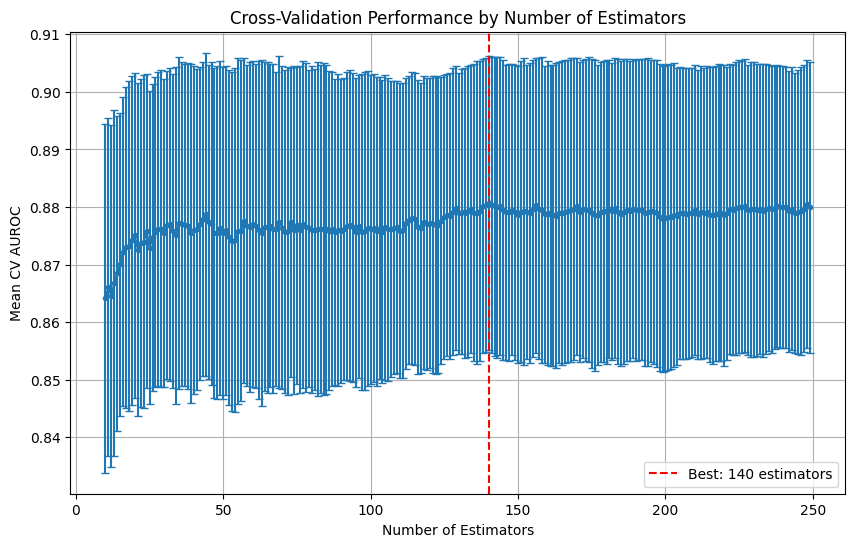

In [10]:
print("Training with 10-fold cross-validation")
start_estimator = 10
max_estimator = 250
# Lists to track performance metrics
mean_cv_aurocs = []  # Track mean cross-validation AUROCs
std_cv_aurocs = []   # Track standard deviation of cross-validation AUROCs
best_mean_auroc = 0  # Track the best mean CV AUROC
best_model = None    # Store the best model
best_estimator_count = 0  # Track which estimator count gave the best model

# Import necessary libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import numpy as np

# Create progress bar for long running process
for i in tqdm(range(start_estimator, max_estimator)):
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_aurocs = []
    
    # Create model with current number of estimators
    clf = train_clf_RF(i)
    
    # Perform cross-validation
    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split data for this fold
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
        
        # Train model on this fold's training data
        clf.fit(X_fold_train, y_fold_train)
        
        # Evaluate on this fold's validation data
        pred_probas_val = clf.predict_proba(X_fold_val)
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y_fold_val, pred_probas_val[:,1])
        roc_auc_val = auc(fpr, tpr)
        fold_aurocs.append(roc_auc_val)
    
    # Calculate mean and standard deviation of AUROC across folds
    mean_auroc = np.mean(fold_aurocs)
    std_auroc = np.std(fold_aurocs)
    
    # Store the results
    mean_cv_aurocs.append(mean_auroc)
    std_cv_aurocs.append(std_auroc)
    
    print(f"Estimators: {i}, Mean CV AUROC: {mean_auroc:.4f} ± {std_auroc:.4f}")
    
    # Check if this is the best model so far
    if mean_auroc > best_mean_auroc:
        best_mean_auroc = mean_auroc
        best_estimator_count = i
        
        # Train a final model with the best parameters on the full training set
        best_model = train_clf_RF(i)
        best_model.fit(X_train, y_train)

# Print information about the best model
print(f"\nBest model had {best_estimator_count} estimators with mean CV AUROC: {best_mean_auroc:.4f}")

# If you want to evaluate the best model on a test set (if available)
if 'X_test' in locals() and 'y_test' in locals():
    test_preds = best_model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, test_preds[:,1])
    test_auroc = auc(fpr, tpr)
    print(f"Test set AUROC for best model: {test_auroc:.4f}")

# If you want to save the best model to disk
import joblib
joblib.dump(best_model, 'best_model_cv_merged_rf.pkl')
print("Best model saved as 'best_model_cv.pkl'")

# Optionally, plot the performance curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.errorbar(range(start_estimator, max_estimator), 
             mean_cv_aurocs, 
             yerr=std_cv_aurocs, 
             fmt='-o', 
             markersize=3, 
             capsize=3)
plt.axvline(x=best_estimator_count, color='r', linestyle='--', 
            label=f'Best: {best_estimator_count} estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean CV AUROC')
plt.title('Cross-Validation Performance by Number of Estimators')
plt.grid(True)
plt.legend()
plt.savefig('rf_cv_performance.png')
plt.show()

In [11]:
clf = RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy', n_jobs=-1, random_state=42,
                            max_features='log2', 
                            n_estimators=140,
                            min_samples_split=0.01,
                            min_samples_leaf=0.005,
                            min_impurity_decrease=1e-2,
                            bootstrap=True,
                            ccp_alpha=1e-2,
                            max_samples=0.75,
                            oob_score=True)
clf = CalibratedClassifierCV(clf, cv=5, method="isotonic")

Train


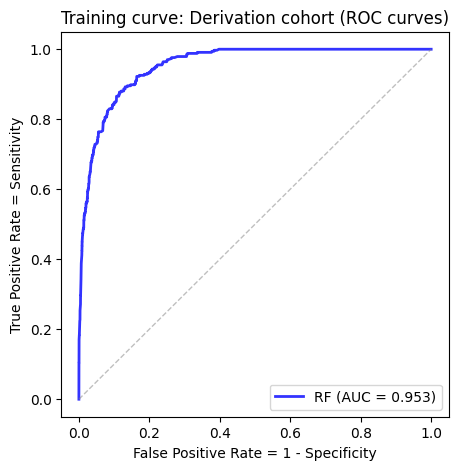

Training AUROC: 0.953 (95% CI: 0.945, 0.961)


In [12]:
print("Train")
    
clf.fit(X_train, y_train)
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")

Validation


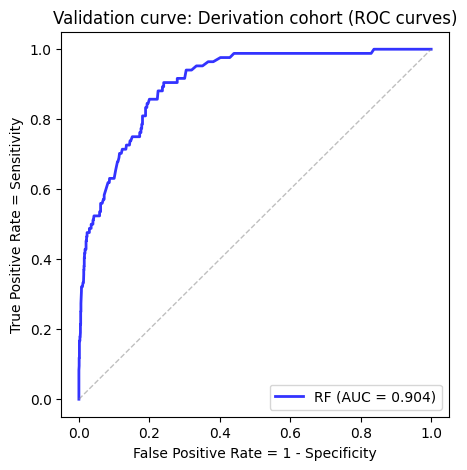

Val AUROC: 0.904 (95% CI: 0.873, 0.932)


In [13]:
print('Validation')
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_val, pred_probas_val[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")